<a href="https://colab.research.google.com/github/ashikshafi08/Learning-Fastai/blob/main/Language_Model_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
# Installing the latest version 
#!pip install -Uqq fastbook
import fastai 
fastai.__version__

'2.5.6'

In [59]:
from fastai.text.all import * 

# Loading the dataset to experiment with 
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

(#2) [Path('/root/.fastai/data/human_numbers/valid.txt'),Path('/root/.fastai/data/human_numbers/train.txt')]

In [60]:
# Opening the files and joining all the texts 

lines = L()

# Opening  the train txt 
with open(path / 'train.txt') as f:
  lines += L(*f.readlines())

# For the valid text 
with open(path / 'valid.txt') as f:
  lines += L(*f.readlines())

lines

(#9998) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

In [61]:
# Now joining all those texts into one big stream of strings 
text = ' . '.join([l.strip() for l in lines])
text[:50]

'one . two . three . four . five . six . seven . ei'

Now split the text and create tokens of it. 

In [62]:
# Splitting by space getting the texts as tokens 

tokens = text.split(' ')
tokens[:10]

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

Now we got the tokens but to numericalize it we need a **vocabulary** that contains the unique tokens from our corpus of tokens. 

So lets get a vocab of unique tokens. 

In [63]:
# Getting the vocab (unique tokens)
vocab = L(*tokens).unique()
vocab[:10]

(#10) ['one','.','two','three','four','five','six','seven','eight','nine']

In [64]:
# Checking the length of the tokens and vocab
len(vocab), len(tokens)

(30, 63095)

Since we got the vocab lets convert our tokens into numbers by looking up the index of each in the vocab. 

This means for every unique token we assign a number. 


In [65]:
word2idx = {w:i for i , w in enumerate(vocab)}
word2idx

{'.': 1,
 'eight': 8,
 'eighteen': 18,
 'eighty': 26,
 'eleven': 11,
 'fifteen': 15,
 'fifty': 23,
 'five': 5,
 'forty': 22,
 'four': 4,
 'fourteen': 14,
 'hundred': 28,
 'nine': 9,
 'nineteen': 19,
 'ninety': 27,
 'one': 0,
 'seven': 7,
 'seventeen': 17,
 'seventy': 25,
 'six': 6,
 'sixteen': 16,
 'sixty': 24,
 'ten': 10,
 'thirteen': 13,
 'thirty': 21,
 'thousand': 29,
 'three': 3,
 'twelve': 12,
 'twenty': 20,
 'two': 2}

Using the above dict lets convert our tokens into numbers. 

In [66]:
nums = L(word2idx[t] for t in tokens)
nums[:20]

(#20) [0,1,2,1,3,1,4,1,5,1...]

In [67]:
word2idx[tokens[29]] , tokens[29]

(1, '.')

Now we got a small dataset we can experiment with. 

## Our Language Model From Scratch 

We can turn this into a NN problem, where we are going to predict each word based on the previous three words. How we will approach this? 

1. Independent Variables -> list of sequence of three words
2. Dependent Variable -> next word after every sequence 





In [68]:
# Lets see how does it look in practice 

L((tokens[i:i+3] , tokens[i+3]) for i in range(0 , len(tokens)-4 , 3))

(#21031) [(['one', '.', 'two'], '.'),(['.', 'three', '.'], 'four'),(['four', '.', 'five'], '.'),(['.', 'six', '.'], 'seven'),(['seven', '.', 'eight'], '.'),(['.', 'nine', '.'], 'ten'),(['ten', '.', 'eleven'], '.'),(['.', 'twelve', '.'], 'thirteen'),(['thirteen', '.', 'fourteen'], '.'),(['.', 'fifteen', '.'], 'sixteen')...]

Doing the same stuff but now converting them into tensors of numericalized values. Because we will be feeding numbers to our models. 

In [69]:
# Instead of tokens, we parse the numericalized tokens (nums)

seqs= L((tensor(nums[i:i+3]) , nums[i+3]) for i in range(0 , len(tokens)-4 , 3))
seqs[:10]

(#10) [(tensor([0, 1, 2]), 1),(tensor([1, 3, 1]), 4),(tensor([4, 1, 5]), 1),(tensor([1, 6, 1]), 7),(tensor([7, 1, 8]), 1),(tensor([1, 9, 1]), 10),(tensor([10,  1, 11]), 1),(tensor([ 1, 12,  1]), 13),(tensor([13,  1, 14]), 1),(tensor([ 1, 15,  1]), 16)]

Now we can batch the above dataset and use it for our model. 

In [70]:
# Batching the above seqs 
bs = 64 
split = int(len(seqs) * .8)
dls = DataLoaders.from_dsets(seqs[:split] , seqs[split:] , bs = 64 , 
                             shuffle = False)

dls

Now we can create a neural network architecture that takes three words as input and returns a prediction of the probability of each possible next word in the vocab. 

- We will use three standard linear layers but with 2 tweaks, 
  - The first tweak is that the first layer will use only the first word's embedding as activation, then the second layer will use the second embeddings plus the first layer activation, and the same with the third layer where it uses both the third word's embedding plus the second layers output/ 

  ```
  First layer -> First layer activation 
  
  Second layer -> use the second words embedding -> second layer activation + first layer activation 

  same with the third except has the second layer's activation.
```
  - The second tweak is, 
    - All these 3 layers will use the same weight matrix. 
    - layers weight won't change but the values will change as the data moves through layers.
    - Since the weights don't change in a layer we stick with 1 layer and use it for 3 instance. 

In [71]:
# Creating a language model 

class LMModel(Module):

  def __init__(self , vocab_size, n_hidden): 

    self.i_h = nn.Embedding(vocab_size , n_hidden) # word embedding layer 
    self.h_h = nn.Linear(n_hidden , n_hidden) # linear layer with no change in weights
    self.h_o = nn.Linear(n_hidden , vocab_size) # layer to predict the fourth word

  def forward(self, x):
    h = self.i_h(x[: , 0]) # 1st word embedding
    h = F.relu(self.h_h(h))
    h = h + self.i_h(x[: , 1]) # 2nd word embedding + activation of first layer
    h = F.relu(self.h_h(h))
    h = h + self.i_h(x[: , 2]) # 3rd word embedding + activation of 2nd layer
    h = F.relu(self.h_h(h)) 
    return self.h_o(h)



**Breaking down the above code**
- `i_h` input to hidden, this is our embedding layer applied to our numericalize tokens. 
- `h_h` linear layer to create the activation for the next word (hidden to hidden) 
- `h_o` final layer to predict the fourth word, that is (hidden to output). 


#### Below is the pictorial representation of the code 
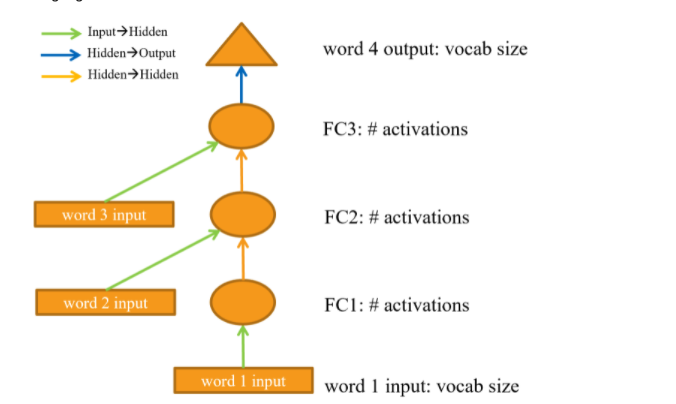

As we know the weight matrix stays the same, and the green arrows are the weight matrix that has been passed to the next layers. 

Also orange arrows represents the activation that changes from layer to layer, because the activation changes as the data moves through the layer. 

In [72]:
# Training the model 

learn = Learner(dls , LMModel(len(vocab) , 64) , 
                loss_func = F.cross_entropy , metrics = accuracy)

# Fitting the model 
learn.fit_one_cycle(4 , 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.740381,2.050205,0.465890,00:02
1,1.384066,1.875530,0.474685,00:02
2,1.413875,1.675168,0.493463,00:02
3,1.377284,1.663418,0.481578,00:02


In [73]:
# Getting the most common 
c = Counter(tokens[split:]) # passing valid set into the counter that will count the occurences
mc = c.most_common(5)

mc

[('thousand', 7104),
 ('.', 7103),
 ('hundred', 6405),
 ('nine', 2440),
 ('eight', 2344)]

What will be the accuracy if our model predicts the common token thousand? 


In [74]:
mc[0][1] / len(tokens[split:]) 

0.15353028894988222

Always predicting this token give us an accuracy of roughly 15%. 

Our forward prop function is messed up with alot of code, we can further refactor it for better understanding. 

In [75]:
# Refactored code 
class LMModel1(Module):

  def __init__(self , vocab_size , n_hidden):
    self.i_h = nn.Embedding(vocab_size , n_hidden)
    self.h_h = nn.Linear(n_hidden , n_hidden)
    self.h_o = nn.Linear(n_hidden , vocab_size)

  def forward(self , x):

    # Initializing the hidden state 
    h = 0 
    for i in range(3): 
      h = h + self.i_h(x[: ,i])
      h = F.relu(self.h_h(h))
    return self.h_o(h)

In [77]:
# Training the model 

learn = Learner(dls , LMModel1(len(vocab) , 64) , 
                loss_func = F.cross_entropy , metrics = accuracy)

# Fitting the model 
learn.fit_one_cycle(4 , 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.797735,1.942218,0.481103,00:02
1,1.365774,1.809790,0.481578,00:02
2,1.417923,1.702087,0.488234,00:02
3,1.399921,1.645249,0.487045,00:02


The above implemented net is also known as a RNN or Reccurent Neural Network. But why? 

Because of the set of activation that has been updated each time through the loop, stored in the variable `h` is called the hidden state and hidden state is a important phenomenon for a RNN layer. 

In other words the activations that gets updated for every time step / step of a rnn. Or a neural network defined using a loop called RNN. 

**RNN is nothing but a simple refactoring of a multilayer neural network using the for loop**. 

## Improving the RNN

The one flaw in our previous RNN is that we are initializing the hiddne state to zero for every new input sequence (h=0 always). 

**Why its a flaw**? 

Basically when we have hidden state 0, it kinda forgets the first mini-batch after it has been predicted. Also with changing hidden state we can predict not only the fourth word but also the third and scond words as well. 



### Maintaining the state of RNN 

When we initialize the models hidden state to zero for each sample, we basically throwing away all the information we have about the sentences we've seen so far. 

We can fix this by using the hidden state as a important parameter in the initializer. 
